# Scheduling: P | p - batch, incompatible | TWT
In diesem Notebook soll das obige Ablaufplanungsproblem mit einer Anwendung der VNS-Metaheuristik (Variable Neighborhood Search) gelöst werden. Das Problem ist eine Verallgemeinerung vom Problem 1 || TWT, welches NP-hart ist. Eine Metaheuristik kann folglich zur effizienten Lösung des Problems angewendet werden.

Zuerst generieren wir ein zufälliges Setup von parallen Maschinen, Produktfamilien mit eigenen Laufzeiten und Jobs.

In [22]:
import numpy as np
import pandas as pd
import random

# parameters for random schedule generation
MIN_JOBS = 50
MAX_JOBS = 200
MIN_BATCH_SIZE = 2
MAX_BATCH_SIZE= 10
MIN_FAMILIES = 5
MAX_FAMILIES = 25
MIN_PROCESSING_TIME = 2
MAX_PROCESSING_TIME = 50
MIN_WEIGHT = 1
MAX_WEIGHT = 10
MIN_DUE_DATE = 8
MAX_DUE_DATE = 200
MIN_MACHINES = 2
MAX_MACHINES = MIN_FAMILIES

# derived parameters
BATCH_SIZE = random.randint(MIN_BATCH_SIZE, MAX_BATCH_SIZE)
NO_OF_JOBS = random.randint(MIN_JOBS, MAX_JOBS)
NO_OF_FAMILIES = random.randint(MIN_FAMILIES, MAX_FAMILIES)
NO_OF_MACHINES = random.randint(MIN_MACHINES, MAX_MACHINES)

# generate a schedule consisting of random jobs
schedule = pd.DataFrame({
    "w": np.random.randint(MIN_WEIGHT, MAX_WEIGHT, size=NO_OF_JOBS), # weight
    "d": np.random.randint(MIN_DUE_DATE, MAX_DUE_DATE, size=NO_OF_JOBS), # due date
    "f": np.empty(NO_OF_JOBS, dtype='object'), # family id
    "p_f": np.full(NO_OF_JOBS, np.nan), # processing time of family
    "atc_S": np.full(NO_OF_JOBS, np.nan), # atc index
    "m": np.empty(NO_OF_JOBS, dtype='object'), # machine id
    "S": np.full(NO_OF_JOBS, np.nan), # start time
    "C": np.full(NO_OF_JOBS, np.nan), # completion time
    "b": np.empty(NO_OF_JOBS, dtype='object'), # batch id
    "batc_S": np.full(NO_OF_JOBS, np.nan), # batch atc index
})

# assign families and family processing times to jobs
p_f = {str(i): random.randint(MIN_PROCESSING_TIME, MAX_PROCESSING_TIME) for i in range(NO_OF_FAMILIES)}

for i, row in schedule.iterrows():
    f = random.choice(list(p_f.keys()))
    schedule.at[i, "f"] = f
    schedule.at[i, "p_f"] = p_f[f]

# show schedule
schedule

,w,d,f,p_f,atc_S,m,S,C,b,batc_S
0,7,30,0,46.0,NaN,None,NaN,NaN,None,NaN
1,4,9,12,49.0,NaN,None,NaN,NaN,None,NaN
2,7,11,3,10.0,NaN,None,NaN,NaN,None,NaN
3,9,39,11,12.0,NaN,None,NaN,NaN,None,NaN
4,8,161,6,10.0,NaN,None,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...
121,8,71,1,47.0,NaN,None,NaN,NaN,None,NaN
122,2,75,3,10.0,NaN,None,NaN,NaN,None,NaN
123,9,168,9,35.0,NaN,None,NaN,NaN,None,NaN
124,2,32,6,10.0,NaN,None,NaN,NaN,None,NaN


Die generierten Zufallsjobs verfügen über folgende statistische Kennzahlen:

In [23]:
schedule[["w", "d", "p_f"]].describe()

,w,d,p_f
count,126.000000,126.000000,126.000000
mean,5.301587,107.484127,30.333333
std,2.754690,59.734577,15.616402
min,1.000000,9.000000,9.000000
25%,3.000000,57.750000,12.000000
50%,6.000000,104.500000,29.000000
75%,8.000000,166.000000,46.000000
max,9.000000,198.000000,49.000000


## Eröffnungsheuristik: ATC-BATC-Heuristic

Mittels der ATC-BATC-Heuristik wird ein initialer Ablaufplan festgelegt. Dafür werden verschiene Werte für $\kappa$ durchprobiert. Die Heuristik greift auf die TWT- und ATC-Funktionen zurück.

TWT-Funktion: $\sum_{j=1}^n w_j T_j = \sum_{j=1}^n w_j \max\{C_j - d_j; 0\}$

In [24]:
def calculate_twt(job: pd.DataFrame) -> int:
    return sum(job.w * np.maximum(job.C - job.d, 0))

ATC-Funktion: $I_j(t) := \frac{w_j}{p_{s(j)}} \exp (-\frac{\max (d_j - p_{s(j)} - t, 0)}{\kappa \overline{p}})$

In [25]:
from math import exp

def calculate_atc(job: pd.Series, p_avg: float, t: int, kappa: int) -> float:
    return (job.w / job.p_f) * exp(-(max(job.d - job.p_f - t, 0))/(kappa * p_avg))

In [26]:
from tqdm import tqdm
import uuid

# total weighted tardiness of the best schedule
atc_batc_twt = None
    
for kappa in [0.5 * l for l in range(1, 11)]:
    #  copy of the schedule to be modified during the search for the best schedule
    temp_schedule = schedule.copy()
    # list of jobs that are not assigned to a machine
    non_assigned_jobs = temp_schedule.copy()
    # machine object with the time when the machine will be free
    machines = pd.Series(np.zeros(NO_OF_MACHINES), name="free_at")
    # time step
    t = 0
    # iterate until all jobs are assigned
    while(non_assigned_jobs.shape[0] > 0):
        # skip if no machine is free
        while len(machines[machines <= t]) > 0:
            # calculate and sort jobs by ATC
            p_avg = non_assigned_jobs.p_f.mean()
            non_assigned_jobs.atc_S = non_assigned_jobs.apply(lambda job: calculate_atc(job, p_avg, 0, kappa), axis=1)
            non_assigned_jobs.sort_values(by="atc_S", ascending=False, inplace=True)
            # get the top batch over all families containing the top min(BATCH_SIZE, NO_OF_JOBS remaining in family) jobs by atc
            batch, batc = None, None
            # iterate over remaining families
            for f in non_assigned_jobs.f.unique():
                # build batch from the remaining jobs of family f and calculate its Batch ATC
                f_remaining = non_assigned_jobs[non_assigned_jobs.f == f]
                f_batch = f_remaining.iloc[:min(BATCH_SIZE, f_remaining.shape[0])]
                f_batc = sum(f_batch.atc_S)
                # if the batch is better than the current best, update the best batch
                if batch is None or f_batc > batc:
                    batch, batc = f_batch.copy(), f_batc
            # break if no batch was found - this should only happen if all jobs are assigned
            if batch is None:
                break
            # assign the best batch to first free machine
            machine_idx = machines[machines <= t].idxmin()
            machines.iloc[machine_idx] = t + batch.p_f.iloc[0]
            # remove the assigned jobs from the non assigned jobs
            non_assigned_jobs.drop(batch.index, inplace=True)
            # overwrite the jobs list with the updated batch
            batch[["m", "S", "C", "b", "batc_S"]] = str(machine_idx), t, t + batch.p_f.iloc[0], f"F{batch.f.iloc[0]}.{str(uuid.uuid4())}", batc
            temp_schedule.update(batch)
        # skip to the next time step when a machine is free
        t = machines.min()
    # update the best schedule if the current one is better
    temp_twt = calculate_twt(temp_schedule)
    print(f"Kappa: {kappa}, TWT: {temp_twt}")
    if atc_batc_twt is None or temp_twt < atc_batc_twt:
        atc_batc_twt = temp_twt
        schedule = temp_schedule

atc_batc_twt = calculate_twt(schedule)
print("-" * 30)
print(f"Best ATC-BATC TWT: {atc_batc_twt}")

Kappa: 0.5, TWT: 8798.0
Kappa: 1.0, TWT: 7336.0
Kappa: 1.5, TWT: 7432.0
Kappa: 2.0, TWT: 7866.0
Kappa: 2.5, TWT: 8188.0
Kappa: 3.0, TWT: 8555.0
Kappa: 3.5, TWT: 9218.0
Kappa: 4.0, TWT: 9334.0
Kappa: 4.5, TWT: 10223.0
Kappa: 5.0, TWT: 10526.0
------------------------------
Best ATC-BATC TWT: 7336.0


Der Plan wird sortiert und der Index auf die Batchbezeichnungen geändert, weil der nächste Optimierungsschritt Batches verwendendet. Anschließend wird der Gantt-Chart für die Zuordnung von Batches zu Maschinen geplottet.

In [27]:
schedule.sort_values(by=["S", "C"], inplace=True)
schedule.set_index("b", inplace=True)
schedule

,w,d,f,p_f,atc_S,m,S,C,batc_S
b,,,,,,,,,
F3.da8ad858-d893-4a88-9283-acbddefe1fd0,7.0,11.0,3,10.0,0.677733,1,0.0,10.0,0.993188
F3.da8ad858-d893-4a88-9283-acbddefe1fd0,8.0,71.0,3,10.0,0.111352,1,0.0,10.0,0.993188
F6.a5d90924-73bc-499e-90e2-fe25b2767cbd,9.0,56.0,6,10.0,0.210340,2,0.0,10.0,0.904735
F3.da8ad858-d893-4a88-9283-acbddefe1fd0,6.0,69.0,3,10.0,0.089092,1,0.0,10.0,0.993188
F6.a5d90924-73bc-499e-90e2-fe25b2767cbd,6.0,45.0,6,10.0,0.198517,2,0.0,10.0,0.904735
...,...,...,...,...,...,...,...,...,...
F6.edd23ed2-2400-4ccf-8d88-8fc18d798a32,8.0,196.0,6,10.0,0.004180,4,186.0,196.0,0.004180
F8.483a3776-3f84-484b-a024-e7fa120a50d9,1.0,142.0,8,43.0,0.002171,0,190.0,233.0,0.002171
F4.9c373a24-5557-4b01-b590-b9aecbcd9fac,2.0,182.0,4,29.0,0.001702,1,194.0,223.0,0.001702


<Figure size 2560x1600 with 0 Axes>

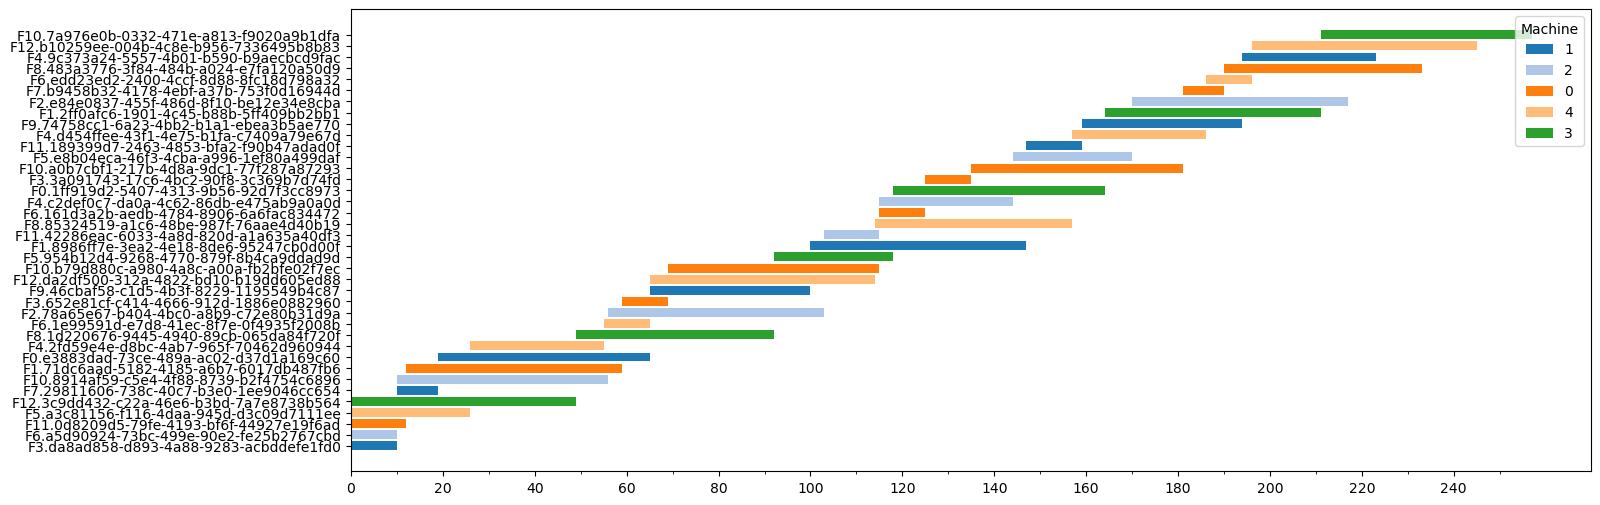

In [28]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch


def plot_gantt_chart(schedule: pd.DataFrame, figsize: tuple=(32, 20), dpi: int=80):
    plt.figure(figsize=(32, 20), dpi=80)
    c_dict = {k: v for k, v in zip(schedule.m.unique(), plt.cm.tab20.colors)}
    fig, ax = plt.subplots(1, figsize=(16,6))
    ax.barh(schedule.index, schedule.C - schedule.S, left=schedule.S, color=schedule.m.map(c_dict))
    ##### LEGENDS #####
    legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
    plt.legend(handles=legend_elements, title="Machine", loc="upper right")
    ##### TICKS #####
    xticks = np.arange(0, schedule.C.max()+1, 20)
    xticks_labels = pd.date_range(schedule.S.min(), end=schedule.C.max())
    xticks_minor = np.arange(0, schedule.C.max()+1, 10)
    ax.set_xticks(xticks)
    ax.set_xticks(xticks_minor, minor=True)
    plt.show()

plot_gantt_chart(schedule)

# Dekompositionsheuristik

Die Dekompositionsheuristik soll die Maschinenbelegung auf den Einzelmaschinen weiter verbessern.

In [29]:
from itertools import permutations

# function to update a modified batch schedule
def update_batch_schedule(machine_schedule: pd.DataFrame) -> pd.DataFrame:
    modified_schedule = machine_schedule.copy()
    S, C = (np.sort(machine_schedule[col].unique()) for col in ["S", "C"])
    indices = machine_schedule.index.unique()
    for i, index in enumerate(indices):
        modified_schedule.loc[index, ["S", "C"]] = S[i], C[i]
        modified_schedule.sort_values(by=["S"], inplace=True)
    return modified_schedule

def dh(ld: int, alpha: int, iter_max: int, schedule: pd.DataFrame):
    # get by machine schedules
    machine_schedules = [m for _, m in schedule.groupby("m")]
    for ms in tqdm(machine_schedules):
        for i in range(iter_max):
            # list of remaining batch ids (starting order) and list of final batch ids (order after applying the heuristic)
            old_ms_order = list(ms.index.unique())
            new_ms_order = list()
            # iterate over segments until all batches are rescheduled
            while len(old_ms_order) > 0:
                # current segment data
                segment_twt = None
                segment_ids = old_ms_order[:min(ld, len(old_ms_order))]
                # iterate over all permutations of the segment
                for permutation in permutations(segment_ids):
                    # get a schedule with the new order of the segment and update the S and C values
                    segment = update_batch_schedule(schedule.loc[list(permutation)])
                    # calculate the segment TWT
                    temp_twt = calculate_twt(segment)
                    # update the best TWT and the best permutation
                    if segment_twt is None or temp_twt < segment_twt:
                        segment_twt = temp_twt
                        segment_ids = list(permutation)
                # add the best permutation to the final order and remove it from the remaining batches
                for id in segment_ids[:min(alpha, len(segment_ids))]:
                    new_ms_order.append(id)
                    old_ms_order.remove(id)
            # record the TWT before and after the heuristic
            old_ms_twt = calculate_twt(ms)
            ms = update_batch_schedule(schedule.loc[new_ms_order])
            new_ms_twt = calculate_twt(ms)
            # update the schedule if the heuristic improved the TWT else no need to continue
            if new_ms_twt < old_ms_twt:
                schedule.loc[new_ms_order] = ms
            else:
                break

dh(5, 2, 15, schedule)
dh_twt = calculate_twt(schedule)
print(f"ATC-BATC TWT: {atc_batc_twt}")
print(f"DH TWT: {dh_twt}")

100%|██████████| 5/5 [00:11<00:00,  2.24s/it]

ATC-BATC TWT: 7336.0
DH TWT: 7009.0


Der verbesserte Plan wird wieder sortiert und geplottet.

In [30]:
schedule.sort_values(by=["S", "C", "b"], inplace=True)
schedule

,w,d,f,p_f,atc_S,m,S,C,batc_S
b,,,,,,,,,
F10.8914af59-c5e4-4f88-8739-b2f4754c6896,3.0,30.0,10,46.0,0.065217,2,0.0,10.0,0.400834
F10.8914af59-c5e4-4f88-8739-b2f4754c6896,3.0,40.0,10,46.0,0.065217,2,0.0,10.0,0.400834
F10.8914af59-c5e4-4f88-8739-b2f4754c6896,7.0,61.0,10,46.0,0.096486,2,0.0,10.0,0.400834
F10.8914af59-c5e4-4f88-8739-b2f4754c6896,8.0,25.0,10,46.0,0.173913,2,0.0,10.0,0.400834
F3.da8ad858-d893-4a88-9283-acbddefe1fd0,7.0,11.0,3,10.0,0.677733,1,0.0,10.0,0.993188
...,...,...,...,...,...,...,...,...,...
F6.edd23ed2-2400-4ccf-8d88-8fc18d798a32,8.0,196.0,6,10.0,0.004180,4,186.0,196.0,0.004180
F8.483a3776-3f84-484b-a024-e7fa120a50d9,1.0,142.0,8,43.0,0.002171,0,190.0,233.0,0.002171
F4.9c373a24-5557-4b01-b590-b9aecbcd9fac,2.0,182.0,4,29.0,0.001702,1,194.0,223.0,0.001702


<Figure size 2560x1600 with 0 Axes>

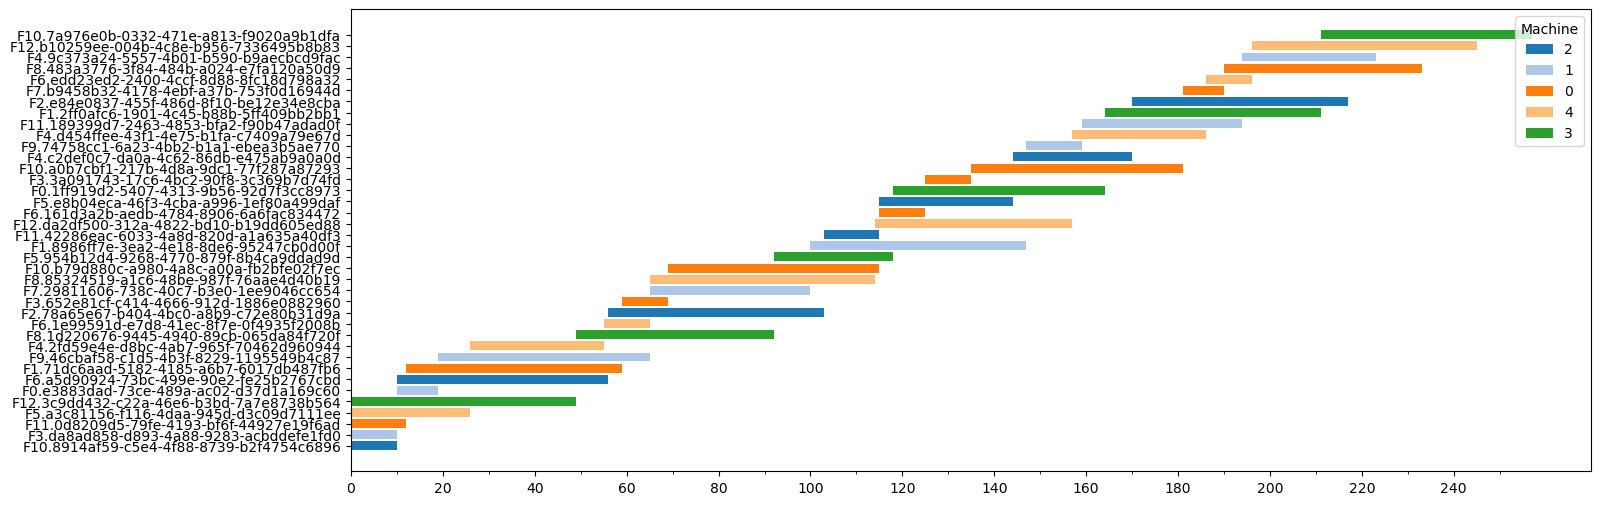

In [31]:
plot_gantt_chart(schedule)

Man sieht, dass sich nur die Werte auf der y-Achse verändert haben, was auch zu erwarten war, da mittels der DH nur die Reihenfolge der Batches auf den Maschinen verändert wird.

## Swap

Für diesen Optimierungsschritt werden wieder primäre einzelne Jobs betrachtet. Der Index wird deshalb zurückgesetzt.

In [32]:
schedule.reset_index(inplace=True, drop=False)
schedule

,b,w,d,f,p_f,atc_S,m,S,C,batc_S
0,F10.8914af59-c5e4-4f88-8739-b2f4754c6896,3.0,30.0,10,46.0,0.065217,2,0.0,10.0,0.400834
1,F10.8914af59-c5e4-4f88-8739-b2f4754c6896,3.0,40.0,10,46.0,0.065217,2,0.0,10.0,0.400834
2,F10.8914af59-c5e4-4f88-8739-b2f4754c6896,7.0,61.0,10,46.0,0.096486,2,0.0,10.0,0.400834
3,F10.8914af59-c5e4-4f88-8739-b2f4754c6896,8.0,25.0,10,46.0,0.173913,2,0.0,10.0,0.400834
4,F3.da8ad858-d893-4a88-9283-acbddefe1fd0,7.0,11.0,3,10.0,0.677733,1,0.0,10.0,0.993188
...,...,...,...,...,...,...,...,...,...,...
121,F6.edd23ed2-2400-4ccf-8d88-8fc18d798a32,8.0,196.0,6,10.0,0.004180,4,186.0,196.0,0.004180
122,F8.483a3776-3f84-484b-a024-e7fa120a50d9,1.0,142.0,8,43.0,0.002171,0,190.0,233.0,0.002171
123,F4.9c373a24-5557-4b01-b590-b9aecbcd9fac,2.0,182.0,4,29.0,0.001702,1,194.0,223.0,0.001702
124,F12.b10259ee-004b-4c8e-b956-7336495b8b83,1.0,158.0,12,49.0,0.002057,4,196.0,245.0,0.002057


Die Optimierung gestaltet sich wie folgt:

In [33]:
def swap(schedule: pd.DataFrame):
    families = schedule.f.unique()
    # batches remaining to be rescheduled
    B_f = schedule.b.to_list()
    # iterate over all families
    for f in tqdm(families):
        if len(B_f) == 0:
            continue
        # get the batch with the smallest S value
        b = schedule[(schedule.f == f) & (schedule.b.isin(B_f)) & (schedule.S == schedule.S.min())]
        # iterate over all jobs in the batch
        break_flag = False
        for this_job in b.iterrows():
            # enable the possibility to break from the inner loop
            if break_flag: break
            # iterate over the jobs in all other batches
            for that_job in schedule[~(schedule.b.isin(b.b)) & (schedule.f == f)].iterrows():
                # create a copy of the schedule
                temp_schedule = schedule.copy()
                # measure the TWT before the swap
                before_twt = calculate_twt(temp_schedule)
                # swap the b, m, S and C values
                temp_schedule.loc[this_job[0], ["b", "m", "S", "C"]] = that_job[1][["b", "m", "S", "C"]]
                temp_schedule.loc[that_job[0], ["b", "m", "S", "C"]] = this_job[1][["b", "m", "S", "C"]]
                # measure the TWT after the swap
                after_twt = calculate_twt(temp_schedule)
                # if the swap improved the TWT then update the schedule
                if after_twt <= before_twt:
                    schedule.update(temp_schedule)
                # if the swap did not improve the TWT then no further improvement is possible
                else:
                    B_f.remove(this_job[1].b)
                    break_flag = True
                    break
            # sort the schedule to keep the order of the batches
            schedule.sort_values(by="S", inplace=True)
            schedule.reset_index(inplace=True, drop=True)

swap(schedule)
print (f"DH TWT: {dh_twt}")
print (f"Swap TWT: {calculate_twt(schedule)}")

100%|██████████| 13/13 [00:00<00:00, 137.43it/s]

DH TWT: 7009.0
Swap TWT: 6969.0


Da sich die Reihenfolge geändert hat, muss neu sortiert werden. Dabei wird auch der Index auf die Batches zurückgesetzt.

In [34]:
schedule.sort_values(by="S", inplace=True)
schedule.set_index("b", inplace=True)
schedule

,w,d,f,p_f,atc_S,m,S,C,batc_S
b,,,,,,,,,
F10.8914af59-c5e4-4f88-8739-b2f4754c6896,3.0,30.0,10,46.0,0.065217,2,0.0,10.0,0.400834
F11.0d8209d5-79fe-4193-bf6f-44927e19f6ad,9.0,39.0,11,12.0,0.307958,0,0.0,12.0,1.165623
F3.da8ad858-d893-4a88-9283-acbddefe1fd0,7.0,11.0,3,10.0,0.677733,1,0.0,10.0,0.993188
F3.da8ad858-d893-4a88-9283-acbddefe1fd0,3.0,57.0,3,10.0,0.065519,1,0.0,10.0,0.135960
F11.0d8209d5-79fe-4193-bf6f-44927e19f6ad,4.0,52.0,11,12.0,0.089163,0,0.0,12.0,1.165623
...,...,...,...,...,...,...,...,...,...
F6.edd23ed2-2400-4ccf-8d88-8fc18d798a32,8.0,196.0,6,10.0,0.004180,4,186.0,196.0,0.004180
F8.483a3776-3f84-484b-a024-e7fa120a50d9,1.0,142.0,8,43.0,0.002171,0,190.0,233.0,0.002171
F4.9c373a24-5557-4b01-b590-b9aecbcd9fac,2.0,182.0,4,29.0,0.001702,1,194.0,223.0,0.001702


<Figure size 2560x1600 with 0 Axes>

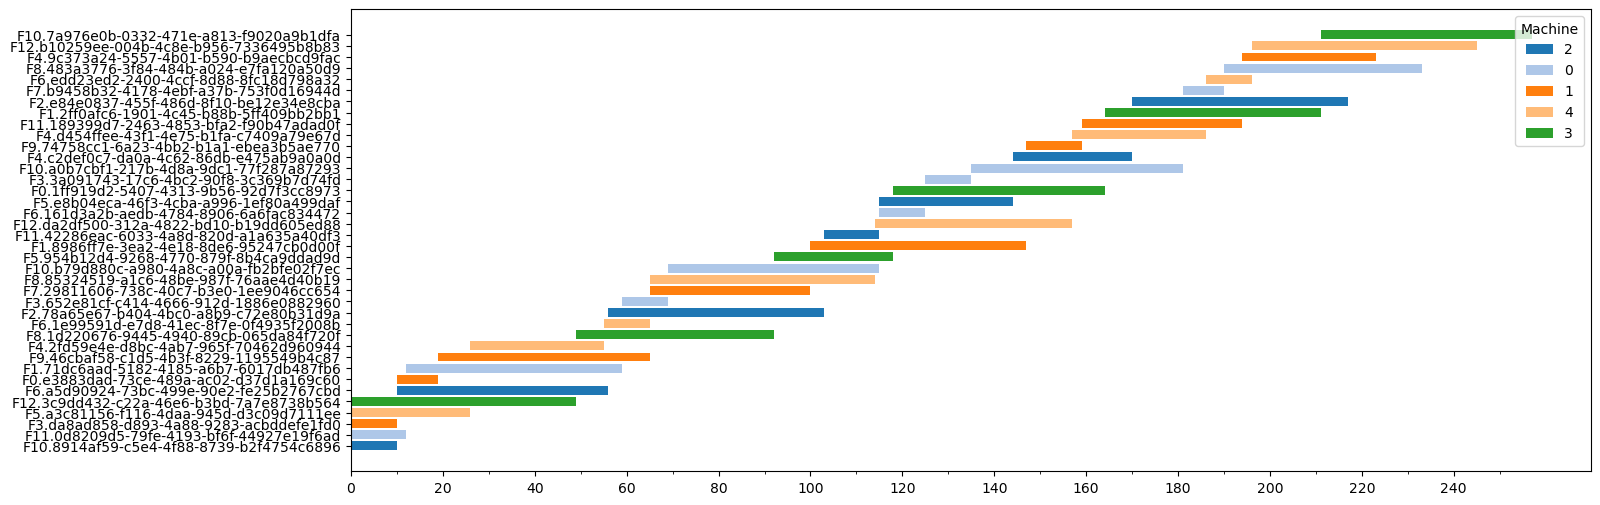

In [35]:
plot_gantt_chart(schedule)

## VNS-Verfahren

In [70]:
from typing import List, Tuple

# helper function for choosing a random machine queue
def random_machines() -> Tuple[str, str]:
    a = random.choice(schedule.m.unique())
    b = random.choice(schedule.m[schedule.m != a].unique())
    return str(a), str(b)

# Neighborhood 1: Swap two batches
def swap(schedule: pd.DataFrame, r: int):
    # get random machines
    m_a, m_b = random_machines()
    # get random batches for each machine
    b_a = random.choice(schedule[schedule.m == m_a].index.unique())
    b_b = random.choice(schedule[schedule.m == m_b].index.unique())
    # swap the batches 
    
    print(schedule.loc[b_a, "m"])
    
twt_before = calculate_twt(schedule)
twt_after = calculate_twt(swap(schedule, 1))
print(f"TWT before: {twt_before}")
print(f"TWT after: {twt_after}")

ValueError: Incompatible indexer with Series

In [37]:
# helper function for choosing a random machine queue and an index 
def random_machine_queues_and_indices() -> Tuple[Tuple[List[Batch], int], Tuple[List[Batch], int]]:
    a, b = random_machine_queues()
    index_a, index_b = random.randint(0, len(a) - 1), random.randint(0, len(b) - 1)
    return (a, index_a), (b, index_b)

# helper function for updating the completion times of batches
def update_completion_times(queue: List[Batch], index: int):
    for i in range(index, len(queue)):
        # add the processing time of the batch to the completion time of the previous batch
        queue[i].C = queue[i].p
        if i > 0:
            queue[i].C += queue[i - 1].C
        # apply the completion time to the jobs of the batch
        queue[i].apply_C_to_jobs()

# Neighborhood 1: Swap two batches
def swap_batch(r: int):
    for i in range(r):
        # get two random machine queues and their indices
        (a, index_a), (b, index_b) = random_machine_queues_and_indices()
        # swap the batches at the indices
        a[index_a], b[index_b] = b[index_b], a[index_a]
        # update the completion times of the batches
        update_completion_times(a, index_a)
        update_completion_times(b, index_b)

# Neighborhood 2: Swap two batch sequences
def swap_seq(r: int):
    # get two random machine queues and their indices
    (a, index_a), (b, index_b) = random_machine_queues_and_indices()
    # swap the batch sequences of length r at the indices
    a[index_a:index_a+r], b[index_b:index_b+r] = b[index_b:index_b+r], a[index_a:index_a+r]
    # update the completion times of the batches
    update_completion_times(a, index_a)
    update_completion_times(b, index_b)

# Neighborhood 3: Move a batch
def move_batch(r):
    for i in range(r):
        # get two random machine queues and their indices
        (a, index_a), (b, index_b) = random_machine_queues_and_indices()
        # remove the batch from the first queue and insert it into the second queue
        b.insert(index_b, a.pop(index_a))
        # update the completion times of the batches
        update_completion_times(a, index_a)
        update_completion_times(b, index_b)

# Neighborhood 4: Move a batch sequence
def move_seq(r):
    # get two random machine queues and their indices
    (a, index_a), (b, index_b) = random_machine_queues_and_indices()
    # remove the batch sequence of length r from the first queue and insert it into the second queue
    for i in range(r):
        if len(a) <= index_a:
            break
        b.insert(index_b+r, a.pop(index_a))
    # update the completion times of the batches
    update_completion_times(a, index_a)
    update_completion_times(b, index_b)

NameError: name 'Batch' is not defined

In [ ]:
import itertools


def balance_workload(machine_queues: List[List[Batch]] = machine_queues):
    while True:
        # get max C of all queues
        C_q_max = [queue[-1].C for queue in machine_queues]
        # get the index r of the queue with max C
        r = C_q_max.index(max(C_q_max))
        # get the index r of the queue with min C
        s = C_q_max.index(min(C_q_max))
        # save total C max
        C_max = C_q_max[r]
        # move last batch from queue r to queue s if C max decreases
        temp_machine_queues = copy.deepcopy(machine_queues)
        temp_machine_queues[s].append(temp_machine_queues[r].pop())
        update_completion_times(temp_machine_queues[r], len(temp_machine_queues[r]) - 1)
        update_completion_times(temp_machine_queues[s], len(temp_machine_queues[s]) - 1)
        if max([queue[-1].C for queue in temp_machine_queues]) < C_max:
            print("here")
            machine_queues = temp_machine_queues
        else:
            break


# TODO     
def swap(machine_queues: List[List[Batch]] = machine_queues):
    S_f = set()
    for index, p in enumerate(p_f):
        B_f_without_S_f = set([batch for queue in machine_queues for batch in queue]) - S_f
        b = min([batch for batch in B_f_without_S_f])
        for job in [batch.jobs for batch in B_f_without_S_f]
        
        
swap()